In [42]:
import numpy as np
import os
import pandas as pd
import scipy.interpolate
import sklearn.metrics
import sys
sys.path.append("../src")
import localmodule


from matplotlib import pyplot as plt
%matplotlib inline

# Define constants.
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
n_thresholds = 221
n_trials = 10
n_eval_trials = 5


# Initialize dicts.
report = {}


# Loop over augmentations.
for aug_kind_str in ["none", "all"]:

    # Initialize dictionaries
    aug_report = {
        "validation": {},
        "test-CV-AUPRC": {},
        "test-CV-F": {},
        "test-oracle-AUPRC": {},
        "test-oracle-F": {},
    }


    val_precisions = np.zeros((n_units, n_trials))
    val_recalls = np.zeros((n_units, n_trials))
    val_f1_scores = np.zeros((n_units, n_trials))
    val_auprcs = np.zeros((n_units, n_trials))
    val_thresholds = np.zeros((n_units, n_trials))
    val_threshold_ids = np.zeros((n_units, n_trials))


    thresholds = 1.0 - np.concatenate((
        np.logspace(-9, -2, 141), np.delete(np.logspace(-2, 0, 81), 0)
    ))
    n_thresholds = len(thresholds)


    # Define model directory
    model_name = "icassp-convnet"
    if not aug_kind_str == "none":
        model_name = "_".join([model_name, "aug-" + aug_kind_str])
    model_dir = os.path.join(models_dir, model_name)


    # Loop over test units.
    for test_unit_id in range(n_units):

        test_unit_str = units[test_unit_id]
        test_unit_dir = os.path.join(model_dir, test_unit_str)

        # Retrieve fold such that unit_str is in the test set.
        folds = localmodule.fold_units()
        fold = [f for f in folds if test_unit_str in f[0]][0]
        test_units = fold[0]
        validation_units = fold[2]

        # Loop over trials.
        for trial_id in range(n_trials):

            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(test_unit_dir, trial_str)
            break_switch = False

            # Loop over validation units.
            for predict_unit_str in validation_units:
                val_metrics_name = "_".join([
                    dataset_name,
                    model_name,
                    "test-" + test_unit_str,
                    trial_str,
                    "predict-" + predict_unit_str,
                    "full-audio-metrics.csv"
                ])
                val_metrics_path = os.path.join(trial_dir, val_metrics_name)
                val_tp = np.zeros((n_thresholds,))
                val_fp = np.zeros((n_thresholds,))
                val_fn = np.zeros((n_thresholds,))
                try:
                    val_metrics_df = pd.read_csv(val_metrics_path)
                    val_tp = val_tp + np.array(val_metrics_df["True positives"])
                    val_fp = val_fp + np.array(val_metrics_df["False positives"])
                    val_fn = val_fn + np.array(val_metrics_df["False negatives"])
                except:
                    break_switch = True
                    break

            if break_switch:
                val_auprc = 0.0
                val_p = np.zeros((n_thresholds,))
                val_r = np.zeros((n_thresholds,))
                val_f = np.zeros((n_thresholds,))
                val_threshold_id = 0
            else:
                val_p = val_tp / (np.finfo(float).eps + val_tp + val_fp)
                val_r = val_tp / (np.finfo(float).eps + val_tp + val_fn)
                val_f = 2*val_p*val_r / (np.finfo(float).eps+(val_p+val_r))
                val_threshold_id = np.argmax(val_f)
                val_p_ = np.array([1.0] + list(val_p) + [0.0])
                val_r_ = np.array([0.0] + list(val_r) + [1.0])
                val_auprc = sklearn.metrics.auc(val_r_, val_p_, reorder=True)

            val_precisions[test_unit_id, trial_id] = val_p[val_threshold_id]
            val_recalls[test_unit_id, trial_id] = val_r[val_threshold_id]
            val_f1_scores[test_unit_id, trial_id] = val_f[val_threshold_id]
            val_thresholds[test_unit_id, trial_id] = thresholds[val_threshold_id]
            val_threshold_ids[test_unit_id, trial_id] = val_threshold_id
            val_auprcs[test_unit_id, trial_id] = val_auprc


    aug_report["validation"]["P"] = val_precisions
    aug_report["validation"]["R"] = val_recalls
    aug_report["validation"]["F"] = val_f1_scores
    aug_report["validation"]["AUPRC"] = val_auprcs
    aug_report["validation"]["threshold"] = val_thresholds
    aug_report["validation"]["threshold_id"] = val_threshold_id
    aug_report["validation"]["trials_F"] = np.argsort(val_f1_scores, axis=1)
    aug_report["validation"]["trials_AUPRC"] = np.argsort(val_auprcs, axis=1)


    # Loop over test trials.
    auprc_eval_trials = np.sort(aug_report["validation"]["trials_AUPRC"][:, -5:], axis=1)
    test_auprcs = np.zeros((n_eval_trials,))
    test_precisions = np.zeros((n_thresholds, n_eval_trials))
    test_recalls = np.zeros((n_thresholds, n_eval_trials))
    test_f1_scores = np.zeros((n_thresholds, n_eval_trials))

    for eval_trial_id in range(n_eval_trials):
        test_tp = np.zeros((n_thresholds,))
        test_fp = np.zeros((n_thresholds,))
        test_fn = np.zeros((n_thresholds,))

        for test_unit_id in range(n_units):
            test_unit_str = units[test_unit_id]
            test_unit_dir = os.path.join(model_dir, test_unit_str)
            trial_id = auprc_eval_trials[test_unit_id, eval_trial_id]
            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(test_unit_dir, trial_str)

            # Load test predictions.
            test_metrics_name = "_".join([
                dataset_name,
                model_name,
                "test-" + test_unit_str,
                trial_str,
                "predict-" + test_unit_str,
                "full-audio-metrics.csv"
            ])
            test_metrics_path = os.path.join(trial_dir, test_metrics_name)
            test_metrics_df = pd.read_csv(test_metrics_path)
            test_tp = test_tp + np.array(test_metrics_df["True positives"])
            test_fp = test_fp + np.array(test_metrics_df["False positives"])
            test_fn = test_fn + np.array(test_metrics_df["False negatives"])

        test_p = test_tp / (np.finfo(float).eps + test_tp + test_fp)
        test_r = test_tp / (np.finfo(float).eps + test_tp + test_fn)
        test_p_ = np.array([1.0] + list(test_p) + [0.0])
        test_r_ = np.array([0.0] + list(test_r) + [1.0])
        test_auprc = sklearn.metrics.auc(test_r_, test_p_, reorder=True)

        test_auprcs[eval_trial_id] = test_auprc
        test_precisions[:, eval_trial_id] = test_p
        test_recalls[:, eval_trial_id] = test_r
        test_f1_scores[:, eval_trial_id] =\
            (2*test_p*test_r) / (np.finfo(float).eps+test_p+test_r)


    aug_report["test-CV-AUPRC"]["AUPRC"] = test_auprcs
    aug_report["test-CV-AUPRC"]["P"] = test_precisions
    aug_report["test-CV-AUPRC"]["R"] = test_recalls
    aug_report["test-CV-AUPRC"]["F"] = test_f1_scores


    all_test_recalls = np.array(list(np.sort(np.ravel(test_recalls))))
    interpolated_precisions = np.zeros((2 + len(all_test_recalls), n_eval_trials))

    for eval_trial_id in range(n_eval_trials):
        precision_interpolator = scipy.interpolate.interp1d(
            np.array([0.0] + list(test_recalls[:, eval_trial_id]) + [1.0]),
            np.array([1.0] + list(test_precisions[:, eval_trial_id]) + [1.0]))
        interpolated_precisions[:, eval_trial_id] =\
            np.array([1.0] + list(precision_interpolator(all_test_recalls)) + [0.0])

    interpolated_recalls = np.array([0.0] + list(all_test_recalls) + [1.0])
    aug_report["test-CV-AUPRC"]["interpolated_P"] = np.sort(interpolated_precisions, axis=1)
    aug_report["test-CV-AUPRC"]["interpolated_R"] = interpolated_recalls
    aug_report["test-CV-AUPRC"]["interpolated_F"] =\
        (2*aug_report["test-CV-AUPRC"]["interpolated_P"]*aug_report["test-CV-AUPRC"]["interpolated_R"][:, np.newaxis]) /\
        (aug_report["test-CV-AUPRC"]["interpolated_P"]+aug_report["test-CV-AUPRC"]["interpolated_R"][:, np.newaxis])


    # Estimate F1 score.
    f_eval_trials = np.sort(aug_report["validation"]["trials_F"][:, -5:], axis=1)
    test_precisions = np.zeros((n_eval_trials,))
    test_recalls = np.zeros((n_eval_trials,))
    test_f1_scores = np.zeros((n_eval_trials,))

    for eval_trial_id in range(n_eval_trials):
        test_tp = 0
        test_fp = 0
        test_fn = 0

        for test_unit_id in range(n_units):
            test_unit_str = units[test_unit_id]
            test_unit_dir = os.path.join(model_dir, test_unit_str)
            trial_id = f_eval_trials[test_unit_id, eval_trial_id]
            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(test_unit_dir, trial_str)
            
            threshold_id = aug_report["validation"]["threshold_id"]

            # Load test predictions.
            test_metrics_name = "_".join([
                dataset_name,
                model_name,
                "test-" + test_unit_str,
                trial_str,
                "predict-" + test_unit_str,
                "full-audio-metrics.csv"
            ])
            test_metrics_path = os.path.join(trial_dir, test_metrics_name)
            test_metrics_df = pd.read_csv(test_metrics_path)
            test_tp = test_tp + np.array(test_metrics_df["True positives"])[threshold_id]
            test_fp = test_fp + np.array(test_metrics_df["False positives"])[threshold_id]
            test_fn = test_fn + np.array(test_metrics_df["False negatives"])[threshold_id]

        test_p = test_tp / (np.finfo(float).eps + test_tp + test_fp)
        test_r = test_tp / (np.finfo(float).eps + test_tp + test_fn)
        test_f = 2*test_p*test_r / (np.finfo(float).eps+test_p+test_r)

        test_precisions[eval_trial_id] = test_p
        test_recalls[eval_trial_id] = test_r
        test_f1_scores[eval_trial_id] =\
            (2*test_p*test_r) / (np.finfo(float).eps+test_p+test_r)
            
    aug_report["test-CV-F"]["P"] = test_precisions
    aug_report["test-CV-F"]["R"] = test_recalls
    aug_report["test-CV-F"]["F"] = test_f1_scores
    
    report[aug_kind_str] = aug_report

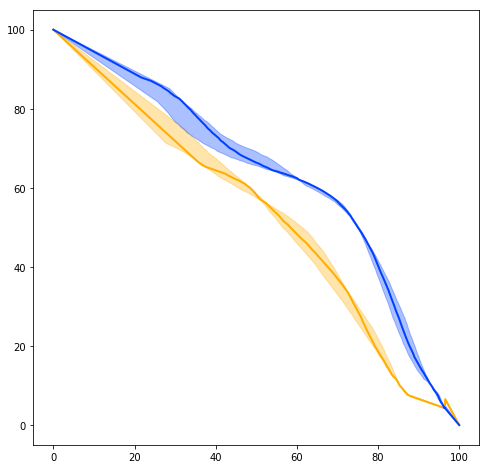

In [263]:
from matplotlib import pyplot as plt
sorted_precisions = np.sort(interpolated_precisions, axis=1)

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8, 8))

ax.fill_between(
    100 * report["none"]["test-CV-AUPRC"]["interpolated_R"],
    100 * report["none"]["test-CV-AUPRC"]["interpolated_P"][:, 1],
    100 * report["none"]["test-CV-AUPRC"]["interpolated_P"][:, 3],
    color = "#FFAD00",
    alpha = 0.33);

ax.plot(
    100 * report["none"]["test-CV-AUPRC"]["interpolated_R"],
    100 * report["none"]["test-CV-AUPRC"]["interpolated_P"][:, 2],
    color = "#FFAD00",
    linewidth = 2.0
)

ax.fill_between(
    100 * report["all"]["test-CV-AUPRC"]["interpolated_R"],
    100 * report["all"]["test-CV-AUPRC"]["interpolated_P"][:, 1],
    100 * report["all"]["test-CV-AUPRC"]["interpolated_P"][:, 3],
    color = "#0040FF",
    alpha = 0.33);

ax.plot(
    100 * report["all"]["test-CV-AUPRC"]["interpolated_R"],
    100 * report["all"]["test-CV-AUPRC"]["interpolated_P"][:, 2],
    color = "#0040FF",
    linewidth = 2.0
)

In [81]:
none_cv_p = report["none"]["test-CV-F"]["P"]
none_cv_r = report["none"]["test-CV-F"]["R"]
none_cv_f = report["none"]["test-CV-F"]["F"]
none_cv_auprc = report["none"]["test-CV-AUPRC"]["AUPRC"]

all_cv_p = report["all"]["test-CV-F"]["P"]
all_cv_r = report["all"]["test-CV-F"]["R"]
all_cv_f = report["all"]["test-CV-F"]["F"]
all_cv_auprc = report["all"]["test-CV-AUPRC"]["AUPRC"]

print("      P = {:5.2f}% +/- {:5.2f}".format(100*np.mean(none_cv_p), 100*np.std(none_cv_p)))
print("[AUG] P = {:5.2f}% +/- {:5.2f}".format(100*np.mean(all_cv_p), 100*np.std(all_cv_p)))
print("")

print("      R = {:5.2f}% +/- {:5.2f}".format(100*np.mean(none_cv_r), 100*np.std(none_cv_r)))
print("[AUG] R = {:5.2f}% +/- {:5.2f}".format(100*np.mean(all_cv_r), 100*np.std(all_cv_r)))
print("")

print("      F = {:5.2f}% +/- {:5.2f}".format(100*np.mean(none_cv_f), 100*np.std(none_cv_f)))
print("[AUG] F = {:5.2f}% +/- {:5.2f}".format(100*np.mean(all_cv_f), 100*np.std(all_cv_f)))
print("")

print("      AUPRC = {:5.2f}% +/- {:5.2f}".format(100*np.mean(none_cv_auprc), 100*np.std(none_cv_auprc)))
print("[AUG] AUPRC = {:5.2f}% +/- {:5.2f}".format(100*np.mean(all_cv_auprc), 100*np.std(all_cv_auprc)))
print("")

      P = 27.59% +/-  1.59
[AUG] P = 43.32% +/-  2.41

      R = 72.82% +/-  3.85
[AUG] R = 78.85% +/-  1.61

      F = 40.01% +/-  2.13
[AUG] F = 55.86% +/-  1.77

      AUPRC = 51.55% +/-  4.25
[AUG] AUPRC = 62.27% +/-  2.00



In [80]:
report["none"]["test-CV-AUPRC"]["AUPRC"]

array([ 0.54357853,  0.53709737,  0.53360769,  0.53259074,  0.43086302])

In [8]:
scipy.stats.ttest_ind(
    report["none"]["test-CV-AUPRC"]["AUPRC"],
    report["all"]["test-CV-AUPRC"]["AUPRC"])

Ttest_indResult(statistic=-4.5589960730472994, pvalue=0.001852349574801112)

In [12]:
scipy.stats.ttest_ind(
    report["none"]["test-CV-F"]["F"],
    report["all"]["test-CV-F"]["F"])

Ttest_indResult(statistic=-11.468093805441301, pvalue=3.0263535709229697e-06)